# Overview
In this notebook we first train continuous time RNNs on the 3-Bit FF Memory Task with different time discretisation steps $\Delta t \in \{1, \frac{1}{3}, 0.1, 0.01\}$. Then, we evaluate them on a single batch of data with different time discretisation steps $\Delta t \in \{1, \frac{1}{3}, 0.1, 0.01\}$.

In [1]:
!pip install equinox
import os
import optax
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

os.chdir('..')
from src.config import get_run_config, get_data_hyperparameters, get_model_hyperparameters, get_optimizer_hyperparameters
from src.data_utils import nbatch_nbit_memory_dataloader, build_nbatch_nbit_memory
from src.model_utils import compile_metadata, generate_model_id, save_model_metadata, load_model, save_model, check_model_exists, clear_model_cache
from src.training import train_model
from src.plotting import plot_dts_experiment, plot_eigenspectra
from src.models import ContinuousTimeRNN
print(os.getcwd())


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
/Users/melinajingtinglaimon/Documents/Computational Neuroscience/RNN-Dynamical-Systems


/Users/melinajingtinglaimon/Documents/Computational Neuroscience/RNN-Dynamical-Systems/src/plotting.py:87: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Input at training $\Delta t$')


# Train or load model

In [2]:
USE_EXISTING_MODELS=True

In [3]:
experiment_dts = [1, 1/3, 0.1, 0.01]

config = get_run_config()
models = []
model_ids = []

for dt in experiment_dts:
  # Hyperparameters
  data_hyperparameters = get_data_hyperparameters(config, dt=dt)
  model_hyperparameters = get_model_hyperparameters(config)
  optimizer_hyperparameters = get_optimizer_hyperparameters()

  # Compile metadata and generate model ID
  metadata = compile_metadata(config, model_hyperparameters, data_hyperparameters, optimizer_hyperparameters)
  model_id = generate_model_id(metadata)
  MODEL_EXISTS = check_model_exists(model_id)

  if USE_EXISTING_MODELS and MODEL_EXISTS:
      model = load_model(model_id, ContinuousTimeRNN)
  else:
      clear_model_cache(model_id)
      model = ContinuousTimeRNN(**model_hyperparameters)

      # Initialize data loader
      iter_data = nbatch_nbit_memory_dataloader(**data_hyperparameters)

      # Train
      optimizer = optax.adam(**optimizer_hyperparameters)
      opt_state = optimizer.init(model)
      model = train_model(model, iter_data, optimizer, opt_state, model_id=model_id, dt=dt, n_training_steps=n_training_steps, log_every=log_every)

  models.append(model)
  model_ids.append(model_id)

A model with the same metadata already exists with id: 79c9c73d503e64ad0c220e72d8895273. Trained steps = 10000.0, Loss = 0.0008644517511129
A model with the same metadata already exists with id: 3812c39a21e05036b4aeb786b785f236. Trained steps = 10000.0, Loss = 0.0011233864352107
A model with the same metadata already exists with id: c7345eb360e9eff2b6a022598c04a54d. Trained steps = 10000.0, Loss = 0.0023399759083986
A model with the same metadata already exists with id: 559bc7aab070e4bea1150e594694c844. Trained steps = 10000.0, Loss = 0.0257388241589069


# Model Hyperparameters

In [4]:
metadata["model_hyperparameters"]

{'n_input': 3,
 'n_hidden': 100,
 'n_output': 3,
 'h0_scale': 0.1,
 'wIn_factor': 1.0,
 'wRec_factor': 0.9,
 'wOut_factor': 1.0,
 'tau': 1.0}

# Loss

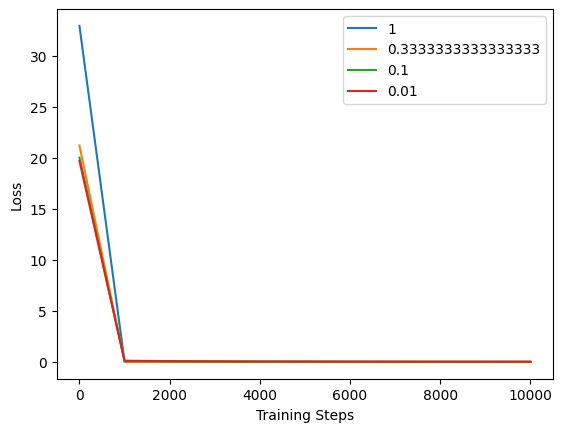

In [5]:
for midx, dt in enumerate(experiment_dts):
  model_id = model_ids[midx]
  loss_path = os.path.join("saved_models", model_id, "loss.csv")
  loss = pd.read_csv(loss_path)["loss"]
  steps = pd.read_csv(loss_path)["step"]
  plt.plot(steps, loss, label=f"{dt}")
  plt.xlabel("Training Steps")
  plt.ylabel("Loss")
plt.legend()
plt.show()

# Unit responses at varied $\Delta t$, of models trained on data with varied $\Delta t$
Reading the graph:
- Each model represents a model trained at different time discretization steps.
- **Row 1**: The inputs. At each column, we display the input upsampled to the time discretization steps of the inputs the model was trained on. Note that this is does not correspond to the input used for the evaluations (and thus plots) in subsequent rows.
- **Row 2**: Hidden unit 1 against time
- **Row 3**: Hidden unit 2 against time
- **Row 4**: Output of the model alongside the actual target values. Note that for dt=1, the switches would be more diagonal, so the output aligns well with the actual target.

Legend:
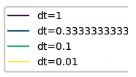



<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_46320/1416897567.py:5: SyntaxWarning: invalid escape sequence '\D'
  model_names= [f"trained on $\Delta t={'1/3' if dt==1/3 else dt}$" for dt in experiment_dts]


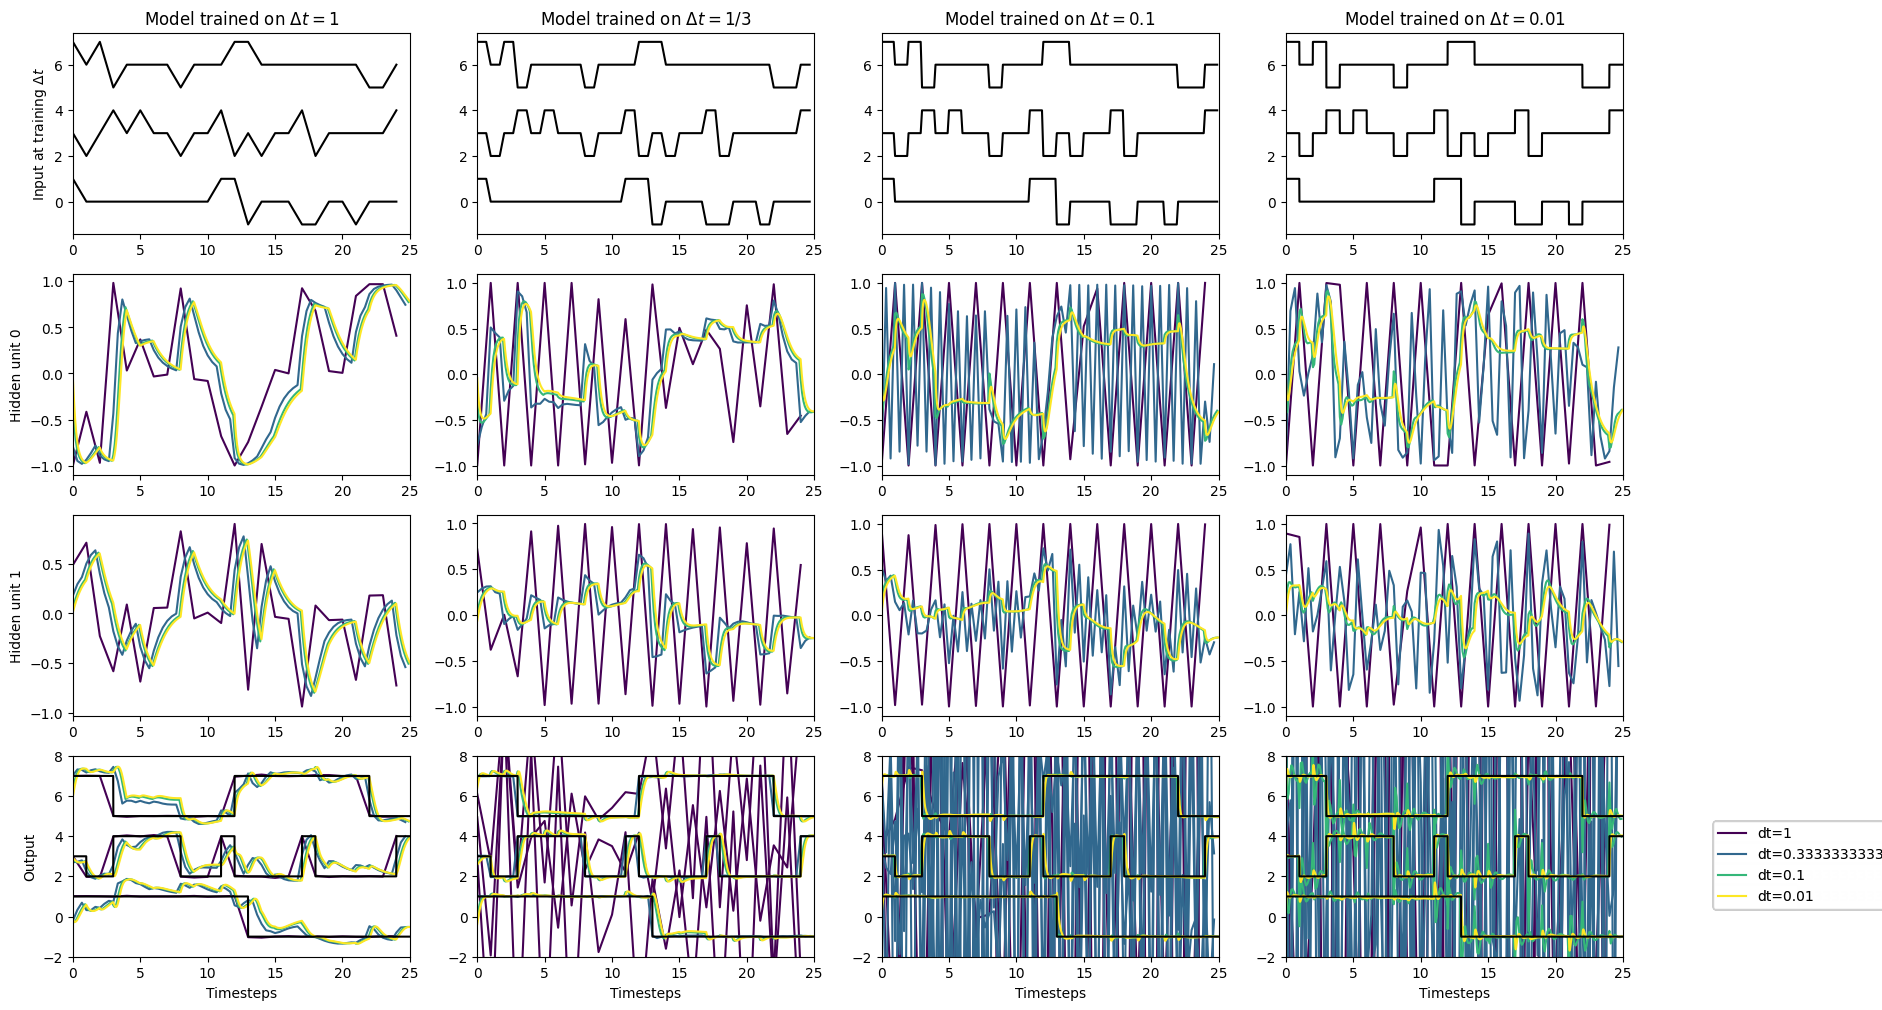

In [6]:
config["seed"] = 0  # Reset seed for evaluation data
n_neurons = 2
data_hyperparameters = get_data_hyperparameters(config, dt=1, batch_size=1)
input_coarse, target_coarse = build_nbatch_nbit_memory(**data_hyperparameters)
model_names= [f"trained on $\Delta t={'1/3' if dt==1/3 else dt}$" for dt in experiment_dts]

plot_dts_experiment(models, experiment_dts, input_coarse[0], target_coarse[0], T=25, n_neurons=n_neurons, model_names=model_names, plot_input=True, plot_dynamics=True, plot_output=True)

# Observations
We make the following observations and attempt to explain them based on the Euler expansion of the continuous time RNN and the eigendecomposition of the recurrent weights matrix plotted below.

**The Euler expansion of the RNN is given by**
$$
\mathbf{x}_{t+1}=(1-\alpha)\mathbf{x}_{t} + \alpha(\mathbf{W}_{rec}f(\mathbf{x}_{t})+\mathbf{W}_{in}\mathbf{u}_{t}+b)
$$
Where $\alpha = \frac{\Delta t}{\tau}$, $\tau=1$

\\

1. **Observation 1**
- For the model trained on training data with $\Delta t = 1$, we observe that the units and output follow the same pattern except as we reduce the discretization steps, the lag increases.
- **Hypothesis:** Smaller $\Delta t \implies $ smaller $\alpha$, thus a larger influence of previous state and more persistent history.

2. **Observation 2**
- For models trained on training data with smaller $\Delta t$, when evaluating data on larger $\Delta t$, we observe oscillations for both the hidden states and the outputs.
- **Hypothesis:** These models have been trained to be more sensitive to perturbations, since at training, the output is more heavily influenced by the previous state $\mathbf{x}_t$. This is evidenced by the eigenvalues of the recurrent connections wRec with observably larger real and imaginary components, which influence the scale and periodicity of the transformation respectively. At large $\Delta t \implies $ smaller $\alpha$, the dynamics become dominated by the sensitive recurrent network and input.

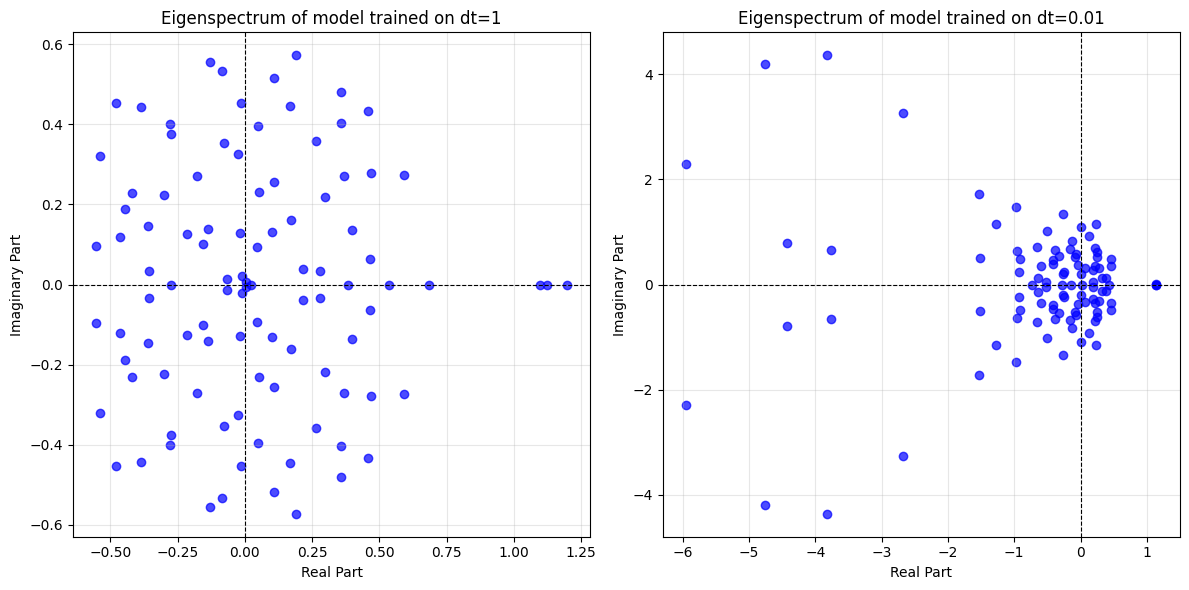

In [7]:
# Compute the eigenvalues
wRecs = [models[0].params["wRec"], models[3].params["wRec"]]
matrix_names = ["model trained on dt=1", "model trained on dt=0.01"]
plot_eigenspectra(wRecs, matrix_names)


# Archive

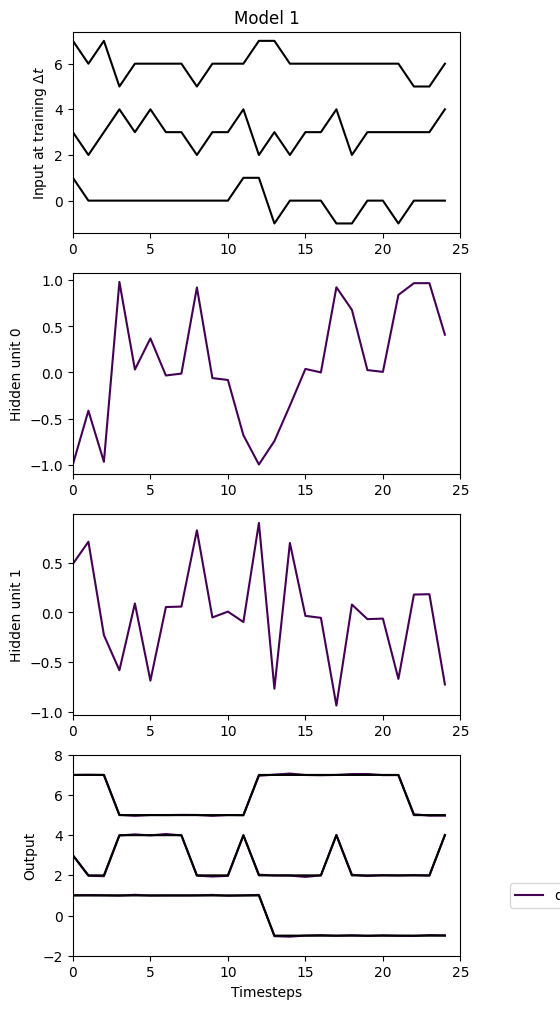

In [8]:
# model trained for dt = 1, evaluated with dt = 1
config["seed"] = 0  # Reset seed for evaluation data
n_neurons = 2
data_hyperparameters = get_data_hyperparameters(config, dt=1, batch_size=1)
input_coarse, target_coarse = build_nbatch_nbit_memory(**data_hyperparameters)
idx = 0
model = [models[idx]]
dt = [experiment_dts[idx]]
plot_dts_experiment(model, dt, input_coarse[0], target_coarse[0], T=25, n_neurons=n_neurons, model_names=dt, plot_input=True, plot_dynamics=True, plot_output=True)